# Data Understanding

In [2]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

C:\Users\Priscila\AppData\Local\Temp\ipykernel_18668\3570558823.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## Data loading

In [3]:
# Create a class that loads and describes our data
class FileLoader:
    def __init__(self, filename=None):
        """
        Initialize the FileLoader object.

        Parameters:
        - filename (str): Optional. The filename of the file to load.
        """
        self.filename = filename
        self.data = None

    def load_csv(self):
        """
        Load a CSV file using the specified filename.
        """
        try:
            self.data = pd.read_csv(self.filename)
            print(f"CSV file '{self.filename}' loaded successfully!")
        except FileNotFoundError:
            print("File not found. Please provide a valid filename.")
            
    def describe(self):
            """
            Display information about the loaded data.
            """
            if self.data is not None:
                # Display the DataFrame shape
                shape = self.data.shape
                print('============================')
                print(f'DataFrame shape: {shape}\n')

                # Display the DataFrame info
                print('================================================================')
                info = self.data.info()
                print(f'DataFrame info: {info}\n')

                # Display the DataFrame description
                print('================================================================')
                description = self.data.describe()
                print(f'DataFrame description: {description}\n')

            else:
                print("No data loaded. Please load a file first using the 'load_csv' method.")

In [4]:
# Create an instance of FileLoader to load our CITES dataset
loader = FileLoader('comptab_2018-01-29 16_00_comma_separated.csv')

# Load the CSV file
loader.load_csv()
raw_data = loader.data

# Describe the loaded data
loader.describe()
# Print the head of the DataFrame
raw_data.head(2)

CSV file 'comptab_2018-01-29 16_00_comma_separated.csv' loaded successfully!
DataFrame shape: (67161, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67161 entries, 0 to 67160
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        67161 non-null  int64  
 1   App.                        67161 non-null  object 
 2   Taxon                       67161 non-null  object 
 3   Class                       46937 non-null  object 
 4   Order                       67104 non-null  object 
 5   Family                      66700 non-null  object 
 6   Genus                       65702 non-null  object 
 7   Importer                    67090 non-null  object 
 8   Exporter                    66588 non-null  object 
 9   Origin                      25643 non-null  object 
 10  Importer reported quantity  31866 non-null  float64
 11  Exporter reported quantity  44021 non-

,Year,App.,Taxon,Class,Order,Family,Genus,Importer,Exporter,Origin,Importer reported quantity,Exporter reported quantity,Term,Unit,Purpose,Source
0,2016,I,Aquila heliaca,Aves,Falconiformes,Accipitridae,Aquila,TR,NL,CZ,NaN,1.0,bodies,NaN,T,C
1,2016,I,Aquila heliaca,Aves,Falconiformes,Accipitridae,Aquila,XV,RS,RS,NaN,1.0,bodies,NaN,Q,O


In [5]:
# profile = ProfileReport(raw_data, title='Pandas Profiling Report', explorative=True)
# profile

## Data Preparation
Preparation of the data involved answering the following questions:
* Does this data contain missing values?
* Are there any outliers?
* Does this data contain any duplicates? 
* Are the values in the expected datatype?
* What is the correlation between various features?
* Do the categorical values require One-Hot encoding?
* Does the dataset require any transformation?

In [6]:
# Create a class that checks for missing values, duplicated rows and outlier from numerical variables
class DataChecker:
    def __init__(self, data):
        self.data = data

    def check_missing_values(self):
        missing_values = self.data.isnull().sum()
        percentage = (self.data.isna().sum() / len(self.data)).round(2)
        missing_values_df = pd.DataFrame({'Missing values': missing_values, 'Percentage': percentage})
        return missing_values_df.sort_values(by='Missing values', ascending=False)

    def check_duplicates(self):
        duplicates = []

        for i in self.data.duplicated():
            duplicates.append(i)
        duplicates_set = set(duplicates)
        
        if len(duplicates_set) == 1:
            return 'The Dataset has No Duplicates'
        else:
            duplicates_percentage = np.round(((sum(duplicates) / len(self.data)) * 100), 5)
            return f'Duplicated rows are {sum(duplicates)} which constitute of {duplicates_percentage} % of our dataset'

    def check_outliers(self, columns):
        fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
        axes = axes.flatten()  # Convert axes array to 1D

        for i, column in enumerate(columns):
            q1 = self.data[column].quantile(0.25)
            q3 = self.data[column].quantile(0.75)
            iqr = q3 - q1
           
            outliers = (self.data[column] < q1 - 1.5 * iqr) | (self.data[column] > q3 + 1.5 * iqr)

            sns.boxplot(data=self.data, x=column, ax=axes[i])
        plt.tight_layout()
        plt.show()

Duplicated rows are 3 which constitute of 0.00447 % of our dataset


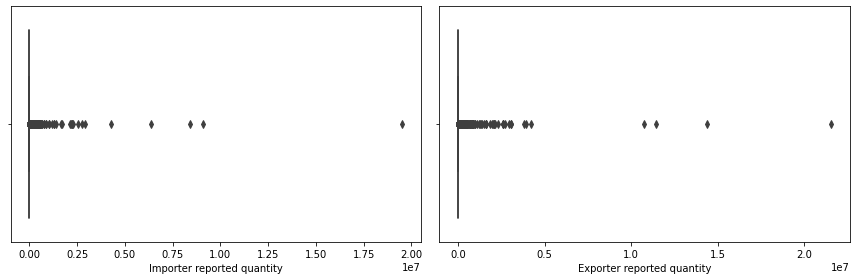

,Missing values,Percentage
Unit,60759,0.90
Origin,41518,0.62
Importer reported quantity,35295,0.53
Exporter reported quantity,23140,0.34
Class,20224,0.30
Purpose,6059,0.09
Genus,1459,0.02
Exporter,573,0.01
Source,544,0.01
Family,461,0.01


In [7]:
# Make of copy of the raw data
copy_data = raw_data.copy()
# Create a DataChecker instance
data_checker = DataChecker(copy_data)

# Check duplicates
duplicates_info = data_checker.check_duplicates()
print( duplicates_info)
print("=========================================================================================")

# Check outliers
num_variables = copy_data[['Importer reported quantity', 'Exporter reported quantity']].dropna()
data_checker.check_outliers(num_variables)
print("=========================================================================================")

# Check missing values
missing_values_df = data_checker.check_missing_values()
missing_values_df

### Dealing With Duplicates

In [8]:
# Drop duplicates
copy_data.drop_duplicates(inplace =True)
copy_data.duplicated().sum()

0

### Dealing with Missing values

In [9]:
# Drop columns
copy_data.drop(['Class', 'Origin','Unit'], axis=1, inplace=True)

# Fill numerical values with `0`
copy_data[['Exporter reported quantity', 'Importer reported quantity']] = copy_data[['Exporter reported quantity', 'Importer reported quantity']].fillna(0)

# impute columns
imp = SimpleImputer(strategy="most_frequent")
copy_data[['Order','Family', 'Genus', 'Importer', 'Exporter', 'Purpose', 'Source']] = imp.fit_transform(copy_data[['Order','Family', 'Genus', 'Importer', 'Exporter', 'Purpose', 'Source']])

data_checker2 = DataChecker(copy_data)
missing_values_df = data_checker2.check_missing_values()
missing_values_df

,Missing values,Percentage
Year,0,0.0
App.,0,0.0
Taxon,0,0.0
Order,0,0.0
Family,0,0.0
Genus,0,0.0
Importer,0,0.0
Exporter,0,0.0
Importer reported quantity,0,0.0
Exporter reported quantity,0,0.0


## Univariate Analysis

### Categorical Variables

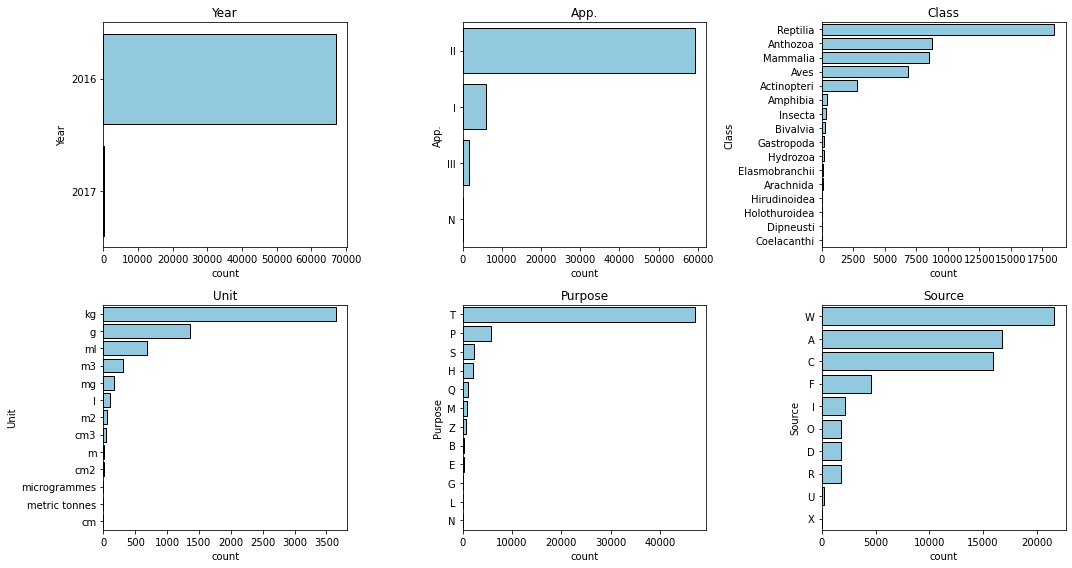

In [10]:
cat_cols = raw_data[['Year', 'App.', 'Class', 'Unit', 'Purpose', 'Source']]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# Iterate over all the axes
ax = axes.flatten()

for i, col in enumerate(cat_cols.columns):
    # Sort the values in descending order of count
    sorted_values = cat_cols[col].value_counts().sort_values(ascending=False).index
    
    # Plot a horizontal histogram for each column with sorted values
    sns.countplot(y=cat_cols[col], order=sorted_values, ax=ax[i], color='skyblue', edgecolor='black')
    ax[i].set_title(col)

fig.tight_layout()
plt.show()

### Numerical Variables

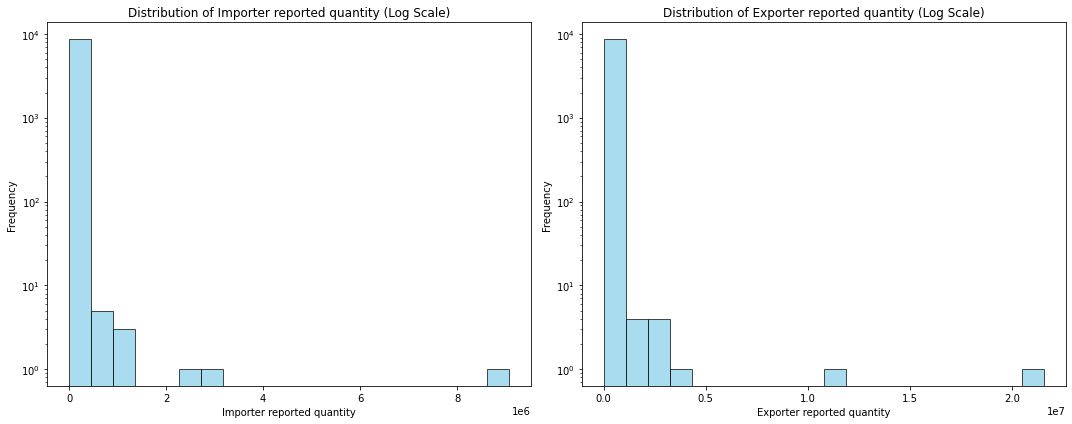

In [11]:
# Create a figure and set subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Iterate over the axes and create customized histograms with log scale
for i, col in enumerate(['Importer reported quantity', 'Exporter reported quantity']):
    data = num_variables[col]
    
    # Customize the histogram appearance
    bins = 20  # Adjust the number of bins as needed
    color = 'skyblue'
    
    # Create the histogram with log scale
    axes[i].hist(data, bins=bins, color=color, log=True, edgecolor='black', alpha=0.7)
    
    axes[i].set_title(f'Distribution of {col} (Log Scale)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust padding
fig.tight_layout()

# Display the plot
plt.show()

### Text Variables

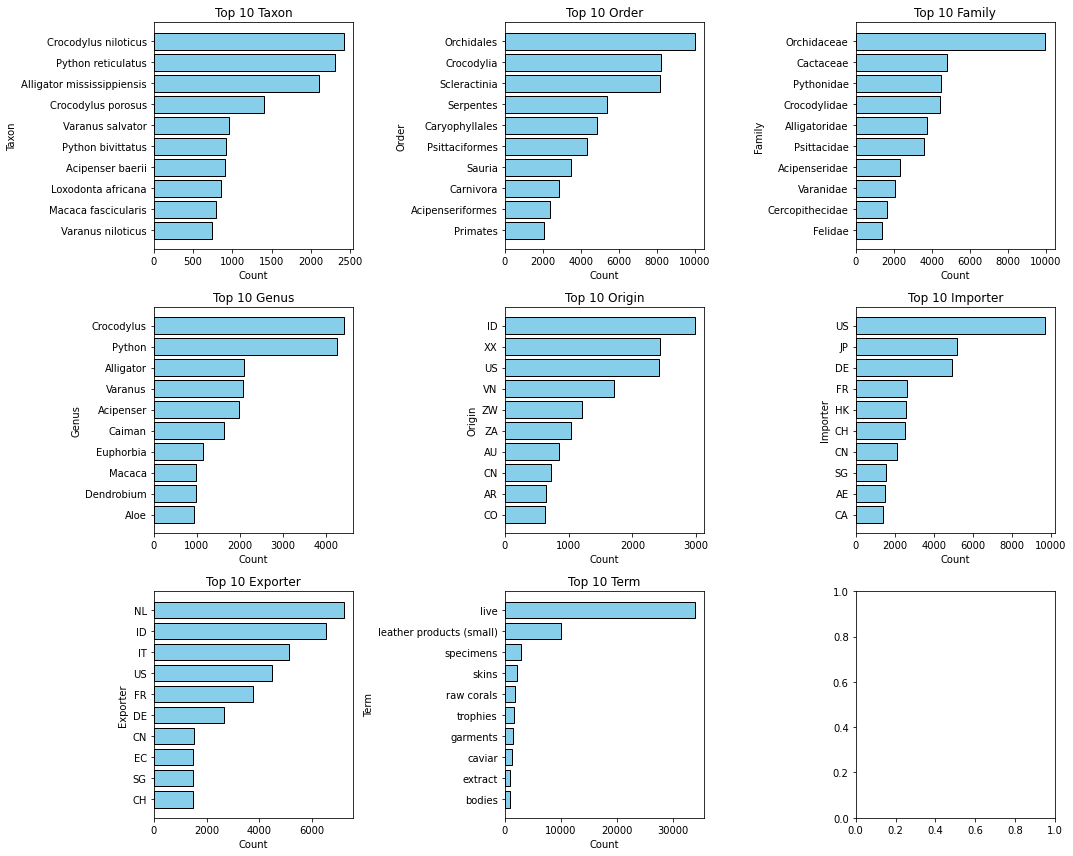

In [12]:
def plot_top_values(data, column_name, ax):
    top_values = data[column_name].value_counts().sort_values(ascending=False)[:10]
    top_values = top_values[::-1]  

    ax.barh(top_values.index, top_values.values, color='skyblue', edgecolor='black')

    ax.set_title(f'Top 10 {column_name}')
    ax.set_xlabel('Count')
    ax.set_ylabel(column_name)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Generate plots for different columns in the grid
columns_to_plot = ['Taxon', 'Order', 'Family', 'Genus', 'Origin','Importer', 'Exporter', 'Term']

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 3)
    plot_top_values(raw_data, column, axes[row, col])

plt.tight_layout()
plt.show()

## Multivariate Analysis

### Classes vs App.

<Figure size 1080x576 with 0 Axes>

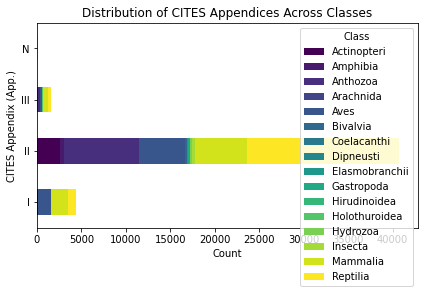

In [13]:
# Create a cross-tabulation of 'App.' and 'Taxon'
cross_tab = pd.crosstab(raw_data['App.'], raw_data['Class'])

# Plot the distribution with improved aesthetics
plt.figure(figsize=(15, 8))

# Use a horizontal bar plot for a cleaner look
cross_tab.plot(kind='barh', stacked=True, colormap='viridis')

plt.title('Distribution of CITES Appendices Across Classes')
plt.xlabel('Count')
plt.ylabel('CITES Appendix (App.)')

# Add a legend for class labels
plt.legend(title='Class', loc='upper right')

plt.tight_layout()
plt.show()

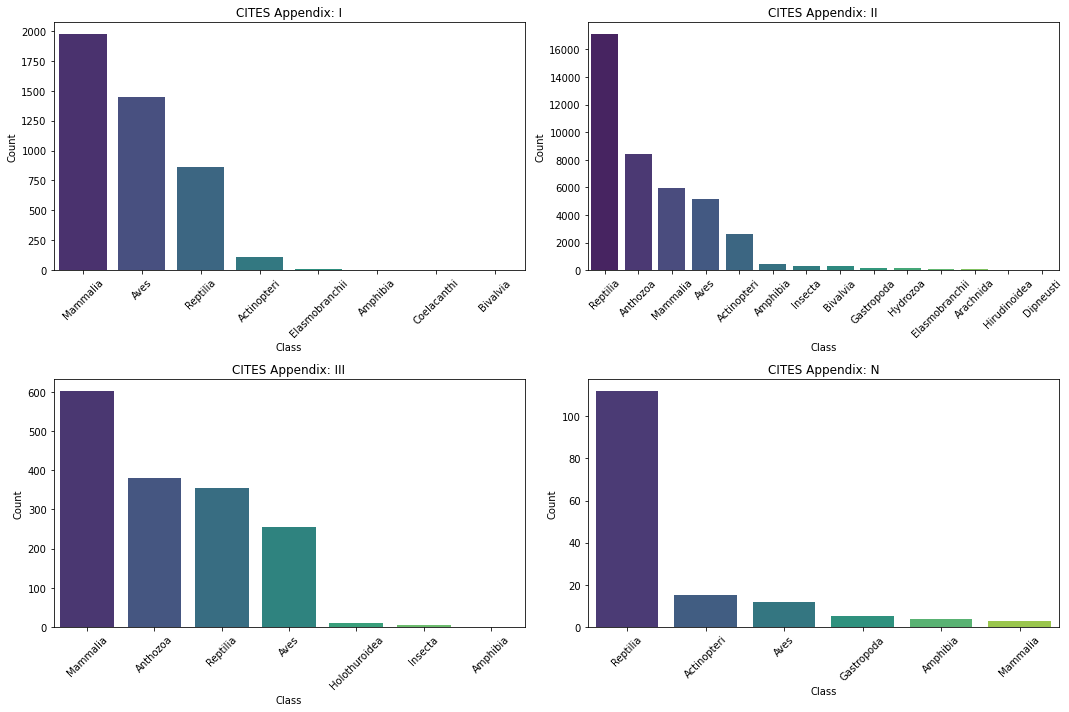

In [22]:
# Get unique categories from the 'App.' column
categories = raw_data['App.'].unique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Create subplots for each category
for i, category in enumerate(categories):
    row, col = divmod(i, 2)

    # Filter raw_data for the current category
    category_data = raw_data[raw_data['App.'] == category]

    # Create a count plot for the 'Class' variable within the current category
    class_order = category_data['Class'].value_counts().index 
    sns.countplot(data=category_data, x='Class', ax=axes[row, col], palette='viridis', order=class_order)

    axes[row, col].set_title(f'CITES Appendix: {category}')
    axes[row, col].set_xlabel('Class')
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


### What are the top 15 `Taxon` being traded across the `App.` categories?

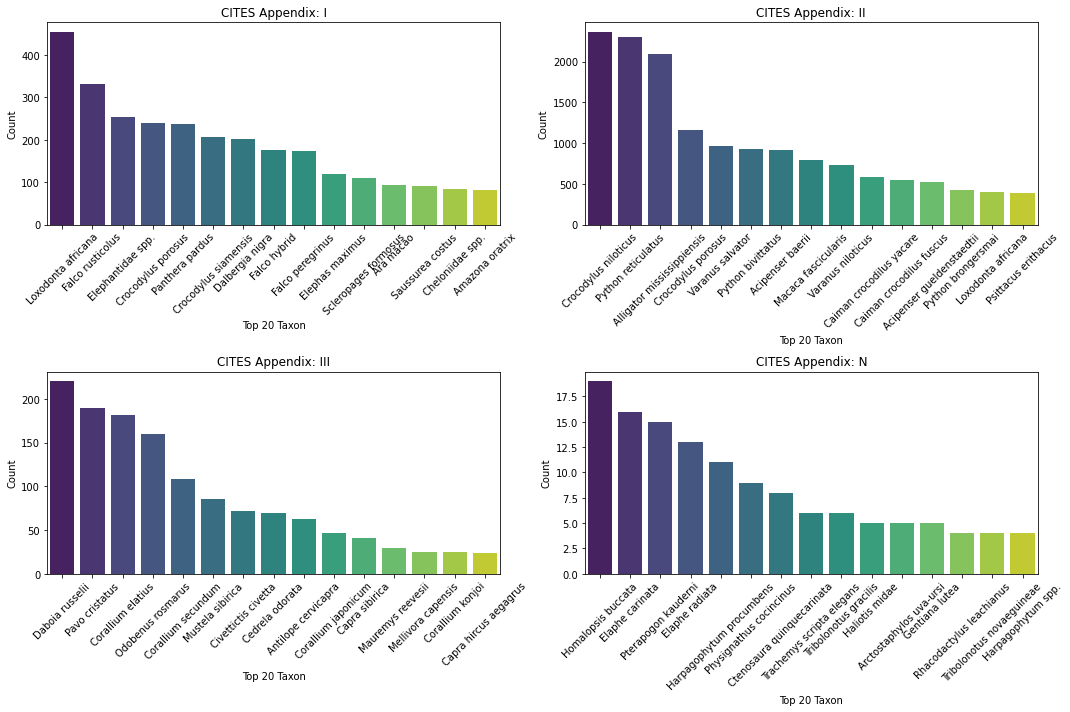

In [29]:
# Define the number of rows and columns for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Get unique categories from the 'App.' column
categories = raw_data['App.'].unique()

# Create subplots for each category
for i, category in enumerate(categories):
    row, col = divmod(i, 2)
    
    # Filter raw_data for the current category
    category_data = raw_data[raw_data['App.'] == category]
    
    # Create a list of the top 15 'Taxon' names for the current category in descending order
    top_20_taxon_names = category_data['Taxon'].value_counts().sort_values(ascending=False)[:15].index
    
    # Filter the data to include only the top 20 'Taxon' names
    category_data_top_20_taxon = category_data[category_data['Taxon'].isin(top_20_taxon_names)]
    
    # Check if the data is not empty before creating the count plot
    if not category_data_top_20_taxon.empty:
        sns.countplot(data=category_data_top_20_taxon, x='Taxon', ax=axes[row, col], palette='viridis', order=top_20_taxon_names)
        
        axes[row, col].set_title(f'CITES Appendix: {category}')
        axes[row, col].set_xlabel('Top 20 Taxon')
        axes[row, col].set_ylabel('Count')
        
        # Set the rotation angle for x-axis labels to 45 degrees
        axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)

# Adjust padding and layout
plt.tight_layout()
plt.show()


### Is there any relationship between the purpose and class being traded?

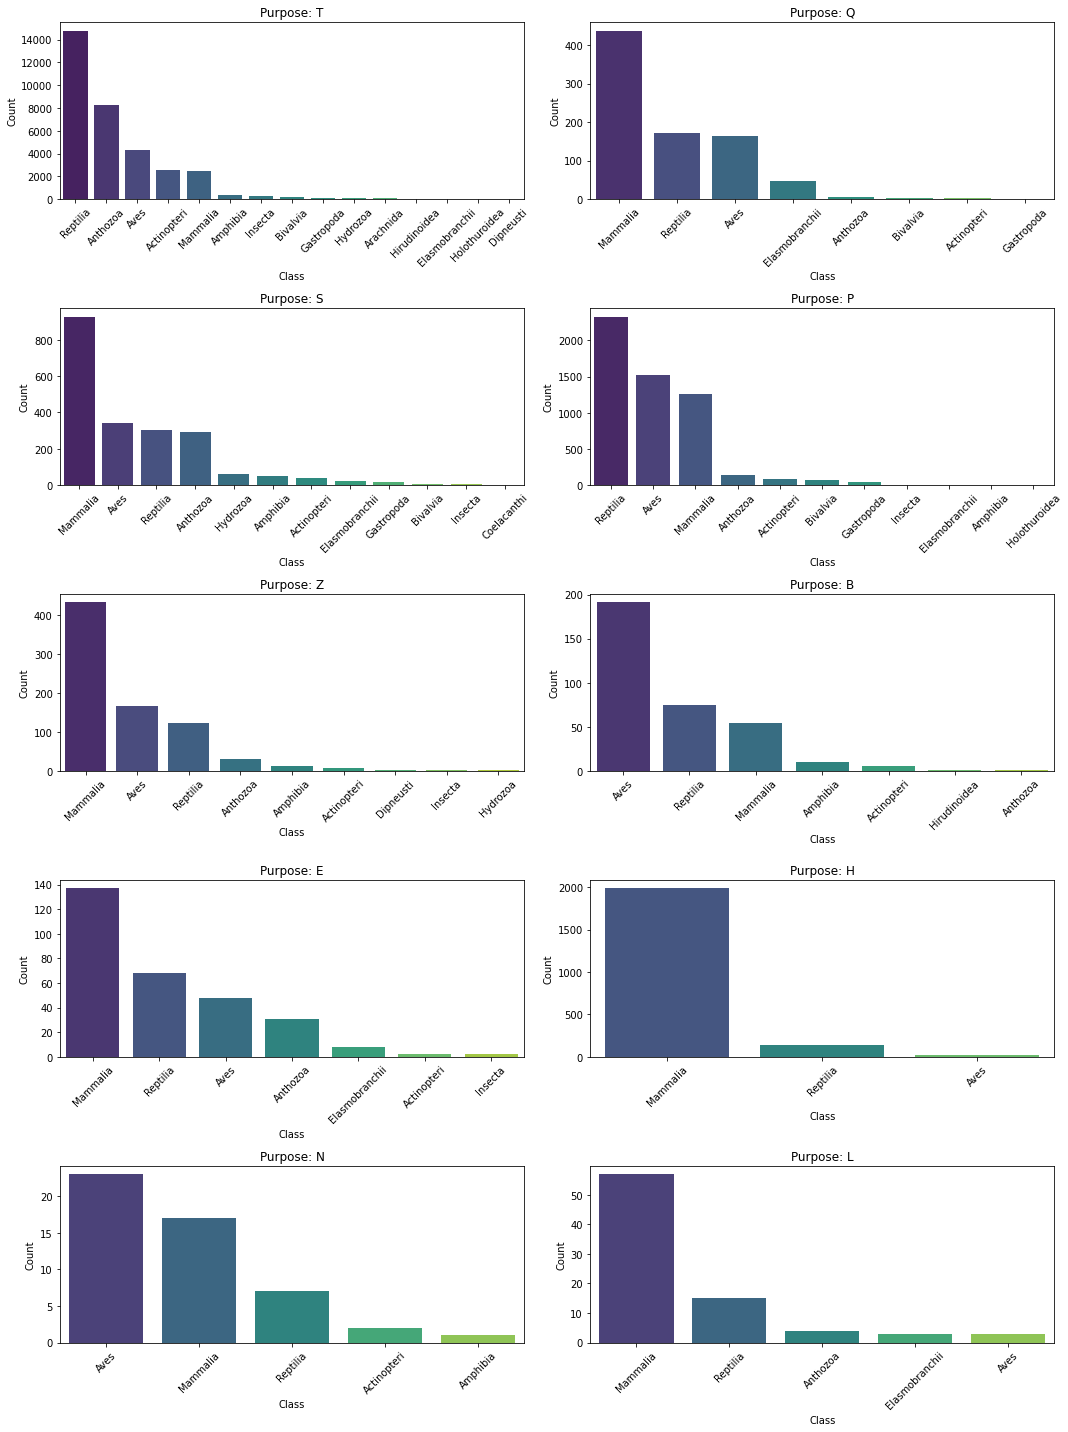

In [38]:
# Select a subset of 'Purpose' categories
selected_purposes = raw_data['Purpose'].unique()[:10]

# Define the number of rows and columns for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Create count plots for the relationship between 'Class' and 'Purpose' for selected categories in descending order
for i, purpose in enumerate(selected_purposes):
    row, col = divmod(i, 2)

    # Filter raw_data for the current purpose
    purpose_data = raw_data[raw_data['Purpose'] == purpose]

    # Create a count plot for the 'Class' variable within the current purpose in descending order
    class_order = purpose_data['Class'].value_counts().index
    ax = sns.countplot(data=purpose_data, x='Class', ax=axes[row, col], palette='viridis', order=class_order)

    axes[row, col].set_title(f'Purpose: {purpose}')
    axes[row, col].set_xlabel('Class')
    axes[row, col].set_ylabel('Count')

    # Set the rotation angle for x-axis labels to 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust padding and layout
plt.tight_layout()
plt.show()


### Top 10 Exporting Countries for App I and App II(Endangered categories)

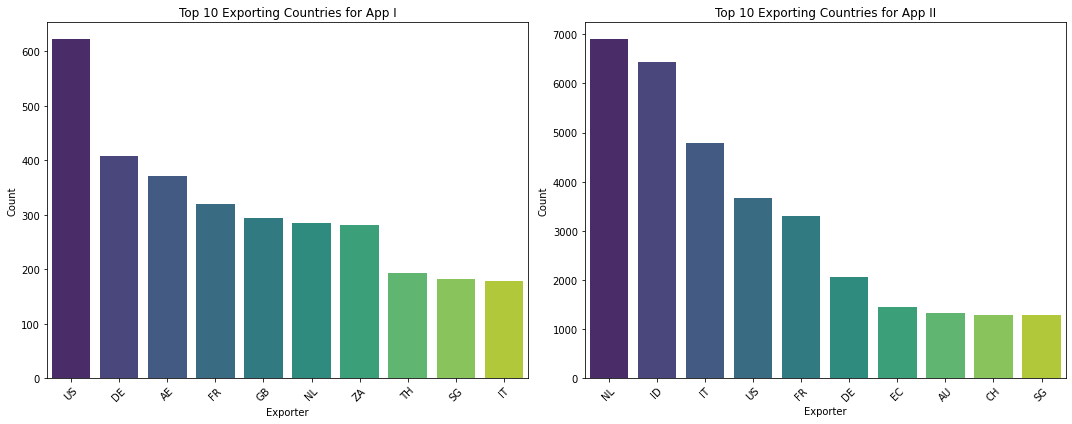

In [17]:
# Filter the data for 'App I' and 'App II' separately
app_i_data = raw_data[raw_data['App.'] == 'I']
app_ii_data = raw_data[raw_data['App.'] == 'II']

# Get the top 10 exporting countries for 'App I' and 'App II'
top_10_exporters_app_i = app_i_data['Exporter'].value_counts().head(10)
top_10_exporters_app_ii = app_ii_data['Exporter'].value_counts().head(10)

# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the top 10 exporting countries for 'App I'
sns.countplot(data=app_i_data, x='Exporter', order=top_10_exporters_app_i.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Exporting Countries for App I')
axes[0].set_xlabel('Exporter')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot the top 10 exporting countries for 'App II'
sns.countplot(data=app_ii_data, x='Exporter', order=top_10_exporters_app_ii.index, ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 Exporting Countries for App II')
axes[1].set_xlabel('Exporter')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Adjust padding and layout
plt.tight_layout()
plt.show()


### What are the main sources of species across all purpose?

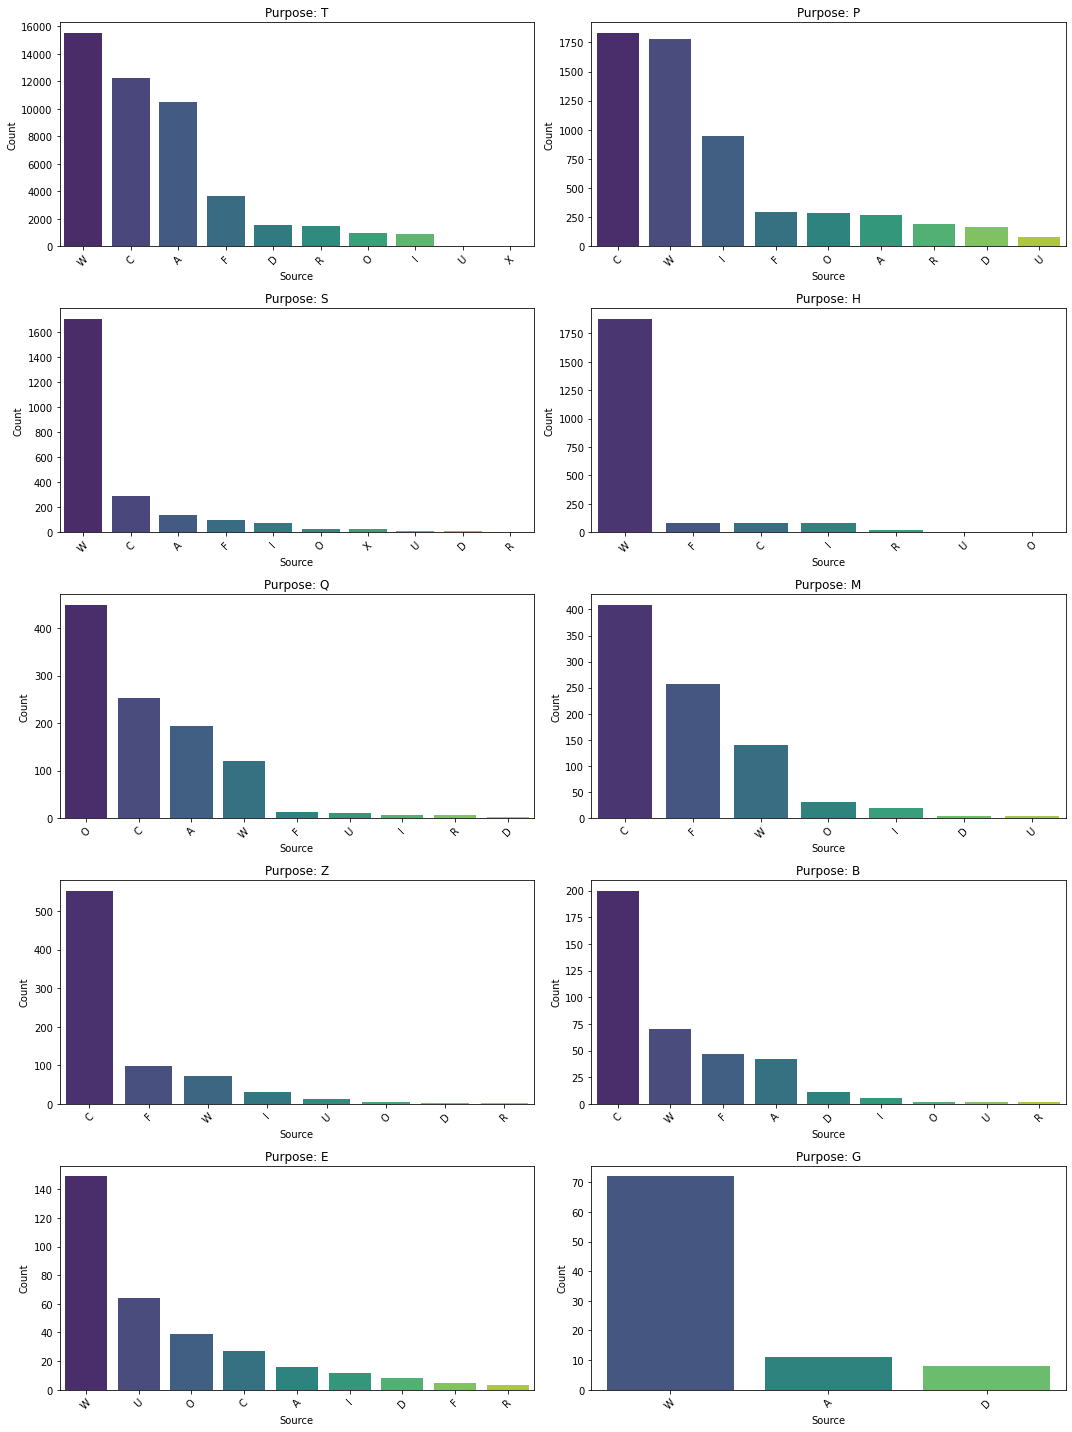

In [40]:
# Select a subset of 'Purpose' categories (the top 10)
selected_purposes = raw_data['Purpose'].value_counts().index[:10]

# Create a filtered DataFrame for the selected purposes
filtered_data = raw_data[raw_data['Purpose'].isin(selected_purposes)]

# Define the number of rows and columns for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

# Create a grouped bar plot for each purpose in descending order of 'Source' counts
for i, purpose in enumerate(selected_purposes):
    row, col = divmod(i, 2)
    
    # Filter data for the current purpose
    purpose_data = filtered_data[filtered_data['Purpose'] == purpose]
    
    # Get the order for 'Source' based on counts in descending order
    source_order = purpose_data['Source'].value_counts().index
    
    # Create a count plot for the 'Source' variable within the current purpose
    ax = sns.countplot(data=purpose_data, x='Source', ax=axes[row, col], palette='viridis', order=source_order)
    
    axes[row, col].set_title(f'Purpose: {purpose}')
    axes[row, col].set_xlabel('Source')
    axes[row, col].set_ylabel('Count')
    
    # Set the rotation angle for x-axis labels to 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust padding and layout
plt.tight_layout()
plt.show()


### How are the top 10 `Taxon` being captured?

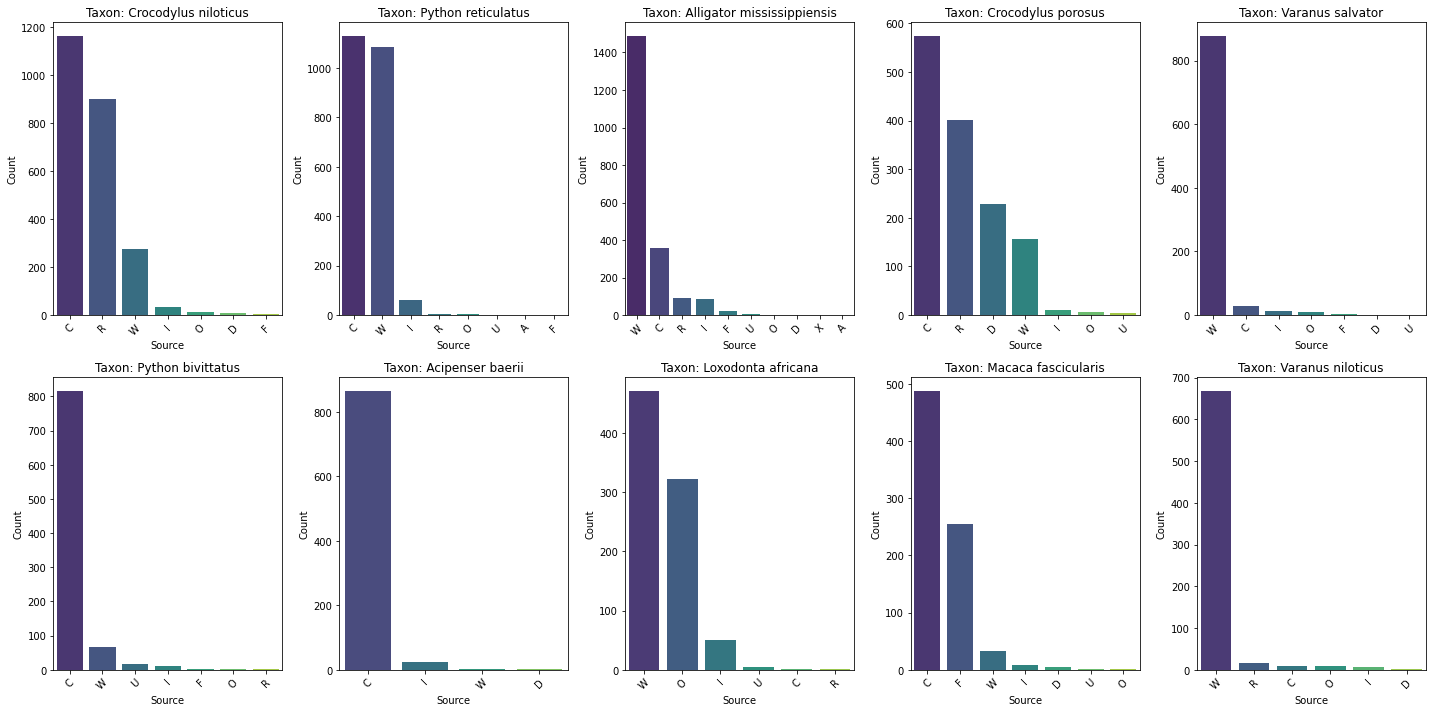

In [49]:
# Get the top ten 'Taxon' categories based on counts
top_10_taxon = raw_data['Taxon'].value_counts().index[:10]

# Define the number of rows and columns for subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Create a grouped bar plot for each of the top ten 'Taxon' categories
for i, taxon in enumerate(top_10_taxon):
    row, col = divmod(i, 5)

    # Filter data for the current 'Taxon' category
    taxon_data = raw_data[raw_data['Taxon'] == taxon]

    # Get the order for 'Source' based on counts in descending order
    source_order = taxon_data['Source'].value_counts().index

    # Create a count plot for the 'Source' variable within the current 'Taxon' category
    ax = sns.countplot(data=taxon_data, x='Source', ax=axes[row, col], palette='viridis', order=source_order)

    axes[row, col].set_title(f'Taxon: {taxon}')
    axes[row, col].set_xlabel('Source')
    axes[row, col].set_ylabel('Count')

    # Set the rotation angle for x-axis labels to 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Hide any empty subplots if there are fewer than 10 'Taxon' categories
if len(top_10_taxon) < 10:
    for i in range(len(top_10_taxon), 10):
        row, col = divmod(i, 5)
        fig.delaxes(axes[row, col])

# Adjust padding and layout
plt.tight_layout()
plt.show()
